In [7]:
import h5py
import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

In [8]:
with h5py.File("../data/tables/20250110/specdiff-segmented.h5", "r") as f:
    embeddings = f["embeddings"][:]
    filenames = [name[0].decode("utf-8") for name in f["filenames"][:]]

print(f"Shape of embeddings: {embeddings.shape}")  # Should be (N, 768)
print(f"Loaded {len(filenames)} filenames")

Shape of embeddings: (5678, 768)
Loaded 5678 filenames


In [9]:
pca = PCA(n_components=50)  # Reduce to 50D while keeping variance
embeddings_pca = pca.fit_transform(embeddings)
print(f"New shape after PCA: {embeddings_pca.shape}")  # (N, 50)

New shape after PCA: (5678, 50)


In [10]:
umap = UMAP(n_components=2, metric="cosine", random_state=42)
embeddings_umap = umap.fit_transform(embeddings_pca)

/Users/finlay/Documents/Programming/disklavier/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/finlay/Documents/Programming/disklavier/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
k = 120  # Choose the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings_pca)

print(f"Cluster assignments: {np.unique(labels, return_counts=True)}")

Cluster assignments: (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119], dtype=int32), array([ 19,  67,  55,  18,  76,  41, 103,  64,  80,  34,  31,  71,  44,
        50,  38,  70,  56,  84,  43,  61, 102,  37,  11,  67,  35,  71,
       102,  46,  42,  56,  30, 159,  50,  48,   5,  43,  28,  29,  91,
        63,  76,  30,  37,  63,   7,  37,   9,  47,  51,  19,   8, 111,
     

In [12]:
clusterer = HDBSCAN(min_cluster_size=10, metric="euclidean")
labels = clusterer.fit_predict(embeddings_pca)

print(f"Unique clusters found: {np.unique(labels)}")

/Users/finlay/Documents/Programming/disklavier/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/finlay/Documents/Programming/disklavier/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Unique clusters found: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76]


In [13]:
score = silhouette_score(embeddings_pca, labels)
print(f"Silhouette Score: {score}")

Silhouette Score: -0.1084674671292305


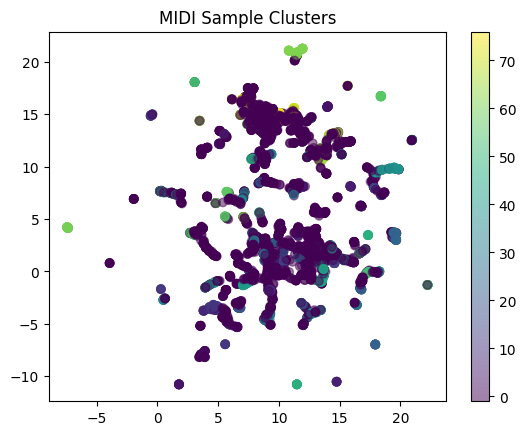

In [14]:
plt.scatter(
    embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels, cmap="viridis", alpha=0.5
)
plt.colorbar()
plt.title("MIDI Sample Clusters")
plt.show()

In [15]:
def interactive_plot(
    embeddings, filenames, clustering_method="kmeans", num_clusters=10
):
    clustering_method = "HDBSCAN"
    # Create DataFrame for Plotly
    df = pd.DataFrame(
        {
            "x": embeddings[:, 0],
            "y": embeddings[:, 1],
            "filename": filenames,
            "cluster": labels.astype(str),  # Convert to string for color mapping
        }
    )

    # Create interactive scatter plot
    fig = px.scatter(
        df,
        x="x",
        y="y",
        hover_name="filename",
        color="cluster",
        title=f"UMAP Projection of MIDI Embeddings (Clusters: {num_clusters}, Method: {clustering_method})",
        labels={
            "x": "UMAP Dimension 1",
            "y": "UMAP Dimension 2",
            "cluster": "Cluster ID",
        },
        color_discrete_sequence=px.colors.qualitative.Set1,
    )

    fig.show()

In [16]:
# Interactive Sliders for UMAP Parameters
n_neighbors_slider = widgets.IntSlider(
    value=15, min=2, max=50, step=1, description="n_neighbors"
)
min_dist_slider = widgets.FloatSlider(
    value=0.1, min=0.0, max=0.99, step=0.01, description="min_dist"
)
cluster_method_dropdown = widgets.Dropdown(
    options=["kmeans", "hdbscan"], value="kmeans", description="Clustering"
)
num_clusters_slider = widgets.IntSlider(
    value=k, min=5, max=150, step=5, description="K-Means Clusters"
)

# Display Interactive Plot
widgets.interactive(
    interactive_plot,
    embeddings=widgets.fixed(embeddings),
    filenames=widgets.fixed(filenames),
    n_neighbors=n_neighbors_slider,
    min_dist=min_dist_slider,
    clustering_method=cluster_method_dropdown,
    num_clusters=num_clusters_slider,
)

interactive(children=(Dropdown(description='Clustering', options=('kmeans', 'hdbscan'), value='kmeans'), IntSl…